In [27]:
!sudo apt -y install msttcorefonts

# Setup tesseract with legacy model
!sudo apt install tesseract-ocr
!wget https://github.com/tesseract-ocr/tessdata/raw/main/eng.traineddata
!mv eng.traineddata /usr/share/tesseract-ocr/4.00/tessdata/

# Poppler for pdf2image
!sudo apt install poppler-utils

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'ttf-mscorefonts-installer' instead of 'msttcorefonts'
ttf-mscorefonts-installer is already the newest version (3.6ubuntu2).
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
--2022-02-25 23:27:08--  https://github.com/tesseract-ocr/tessdata/raw/main/eng.traineddata
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.1

In [12]:
!pip install Pillow==9.0.1 pdf2image pytesseract

In [25]:
from PIL import Image, ImageDraw, ImageFont
import string
import numpy as np
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tqdm
from pdf2image import convert_from_path
import pytesseract

assert torch.cuda.is_available()

In [2]:
FONT_PATH = "/usr/share/fonts/truetype/msttcorefonts/"
FONTS = [
    "Arial",
    "Times_New_Roman",
    "Courier_New",
]
VOCABULARY = list(string.ascii_letters + string.digits + ".,\"-")

In [3]:
class CharacterDataset(Dataset):
    # Seed is used to make sure we always generate the same dataset
    def __init__(self, size, seed):
        super().__init__()
        self.size = size
        self.seed = seed
        self.cache = {}

    def __len__(self):
        return self.size

    @staticmethod
    def pil_to_torch(image):
        image = np.array(image) / 255.0
        image = (image - 0.5) / 0.5
        return torch.from_numpy(image).type(torch.float32).unsqueeze(0)

    @staticmethod
    def letterbox_image(image, img_size, background_color):
        w, h = image.width, image.height

        # Rescale image to have larger side img_size
        if w > h:
            new_w, new_h = img_size, h * img_size // w
        else:
            new_w, new_h = w * img_size // h, img_size
        image = image.resize((new_w, new_h))

        # Paste back into empty image
        new_image = Image.new("L", (img_size, img_size), background_color)
        new_image.paste(image, ((img_size - new_w) // 2, (img_size - new_h) // 2))

        return new_image

    def __getitem__(self, index):
        # Cache computation
        if index in self.cache:
            return self.cache[index]

        # Save rng state so we can restore it later
        rng_state = np.random.get_state()
        # Use seed + index as seed so that we always generate the same instances no matter in what order
        # the dataset is accessed
        np.random.seed(self.seed + index)

        # Random background color
        background_color = 255  # np.random.randint(240, 255 + 1)

        # Random font
        font_type = np.random.choice(FONTS)
        font_size = np.random.randint(15, 25 + 1)
        font_fill = 0  # np.random.randint(0, 15 + 1)
        if np.random.random() < 0.25:
            bold = np.random.randint(0, 2)
            italic = np.random.randint(0, 2)
            if bold:
                font_type += "_Bold"
            if italic:
                font_type += "_Italic"
        else:
            bold = italic = 0
        font_path = os.path.join(FONT_PATH, f"{font_type}.ttf")
        font = ImageFont.truetype(font_path, font_size)

        # Random character
        char = np.random.choice(VOCABULARY)

        # First draw character onto background and get character crop
        img_size = 32

        image = Image.new("L", (img_size, img_size), background_color)
        draw = ImageDraw.Draw(image)
        box = list(draw.textbbox((0, 0), char, font=font))
        w, h = box[2] - box[0], box[3] - box[1]

        assert w <= img_size and h <= img_size
        draw.text(((img_size - w) // 2, (img_size - h) // 2), char, fill=font_fill, font=font)

        # Shift box to center
        box[0] += (img_size - w) // 2
        box[2] += (img_size - w) // 2
        box[1] += (img_size - h) // 2
        box[3] += (img_size - h) // 2

        # Randomly make box coordinates by up to 10% since during inference we usually get imperfect/tighter
        # bounding boxes
        max_x_noise = int(w * 0.1)
        max_y_noise = int(h * 0.1)

        if max_x_noise > 0:
            box[0] = np.clip(box[0] + np.random.randint(max_x_noise // 2, max_x_noise+1), 0, img_size)
            box[2] = np.clip(box[2] + np.random.randint(max_x_noise // 2, max_x_noise+1), 0, img_size)
        if max_y_noise > 0:
            box[1] = np.clip(box[1] + np.random.randint(-max_y_noise, max_y_noise // 2 + 1), 0, img_size)
            box[3] = np.clip(box[3] + np.random.randint(-max_y_noise, max_y_noise // 2 + 1), 0, img_size)

        # Letterbox image to make sure the scale is fixed and the image is square
        char_crop = image.crop(tuple(box))

        image = self.letterbox_image(char_crop, img_size, background_color)

        self.cache[index] = self.pil_to_torch(image), torch.LongTensor([bold, italic])

        np.random.set_state(rng_state)
        return self.cache[index]


In [4]:
train_data = CharacterDataset(10000, 0)
val_data = CharacterDataset(1000, 10000)

bold: 0 italic: 0


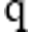


bold: 0 italic: 0


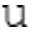


bold: 0 italic: 0


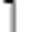


bold: 0 italic: 1


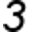


bold: 0 italic: 0


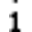


bold: 1 italic: 1


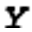


bold: 0 italic: 0


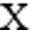


bold: 0 italic: 1


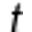


bold: 0 italic: 0


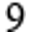


bold: 0 italic: 0


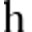

In [6]:
# Print some samples
for i in np.random.randint(0, len(train_data), 10):
  img = train_data[i][0][0]
  print(f"bold: {train_data[i][1][0]} italic: {train_data[i][1][1]}")
  display(Image.fromarray(((img*0.5+0.5)*255).numpy().astype(np.uint8)))
  print()

In [7]:
# Simple CNN with three conv blocks (conv,maxpool,batchnorm,relu)
class CharacterClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        channels = 16
        self.conv1 = nn.Conv2d(1, channels, 3, 1, 1)
        self.bs1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels // 2, 3, 1, 1)
        self.bs2 = nn.BatchNorm2d(channels // 2)
        self.conv3 = nn.Conv2d(channels // 2, channels, 3, 1, 1)
        self.output = nn.Linear(channels * 4 * 4, 2)

    def forward(self, x):
        bsz = x.shape[0]

        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = self.bs1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.bs2(x)
        x = F.relu(x)

        x = self.conv3(x)
        x = F.max_pool2d(x, 2)
        x = x.view(bsz, -1)

        return self.output(x)

In [8]:
train_loader = DataLoader(train_data, batch_size=32)
val_loader = DataLoader(val_data, batch_size=32)

device = torch.device("cuda:0")
model = CharacterClassifier().to(device)

optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [9]:
def compute_tp_fp_fn(preds, y):
    return torch.logical_and(preds == 1, y == 1).sum(dim=0).cpu(),\
           torch.logical_and(preds == 1, y == 0).sum(dim=0).cpu(),\
           torch.logical_and(preds == 0, y == 1).sum(dim=0).cpu()

In [10]:
# Training loop + validation
epoch_range = tqdm.trange(100)
for _ in epoch_range:
    total_loss = 0
    num_batches = 0

    train_tp, train_fp, train_fn = 0, 0, 0
    for batch in train_loader:
        x, y = batch[0].to(device), batch[1].to(device)
        logits = model(x)
        loss = F.binary_cross_entropy_with_logits(logits, y.float())
        preds = logits >= 0

        tp, fp, fn = compute_tp_fp_fn(preds, y)
        train_tp += tp
        train_fp += fp
        train_fn += fn

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.cpu().item()
        num_batches += 1
    train_p = train_tp / (train_tp + train_fp)
    train_r = train_tp / (train_tp + train_fn)
    train_f1 = 2 * (train_p * train_r) / (train_p + train_r)

    # Validation: compute precision, recall and f1
    val_tp, val_fp, val_fn = 0, 0, 0
    with torch.no_grad():
        for batch in val_loader:
            x, y = batch[0].to(device), batch[1].to(device)
            logits = model(x)
            preds = logits >= 0

            tp, fp, fn = compute_tp_fp_fn(preds, y)
            val_tp += tp
            val_fp += fp
            val_fn += fn
    val_p = val_tp / (val_tp + val_fp)
    val_r = val_tp / (val_tp + val_fn)
    val_f1 = 2 * (val_p * val_r) / (val_p + val_r)

    epoch_range.set_description(f"Loss: {total_loss / num_batches:.4f} "
                                f"Train Bold: {train_p[0]:.4f},{train_r[0]:.4f},{train_f1[0]:.4f} Train Italic: {train_p[1]:.4f},{train_r[1]:.4f},{train_f1[1]:.4f} "
                                f"Val Bold: {val_p[0]:.4f},{val_r[0]:.4f},{val_f1[0]:.4f} Val Italic: {val_p[1]:.4f},{val_r[1]:.4f},{val_f1[1]:.4f}")

# torch.save(model, "model.pt")

Loss: 0.0237 Train Bold: 0.9814,0.9555,0.9683 Train Italic: 0.9921,0.9662,0.9790 Val Bold: 0.9576,0.9040,0.9300 Val Italic: 0.9508,0.8467,0.8958: 100%|██████████| 100/100 [03:11<00:00,  1.91s/it]


100%|██████████| 1872/1872 [00:00<00:00, 5321.57it/s]


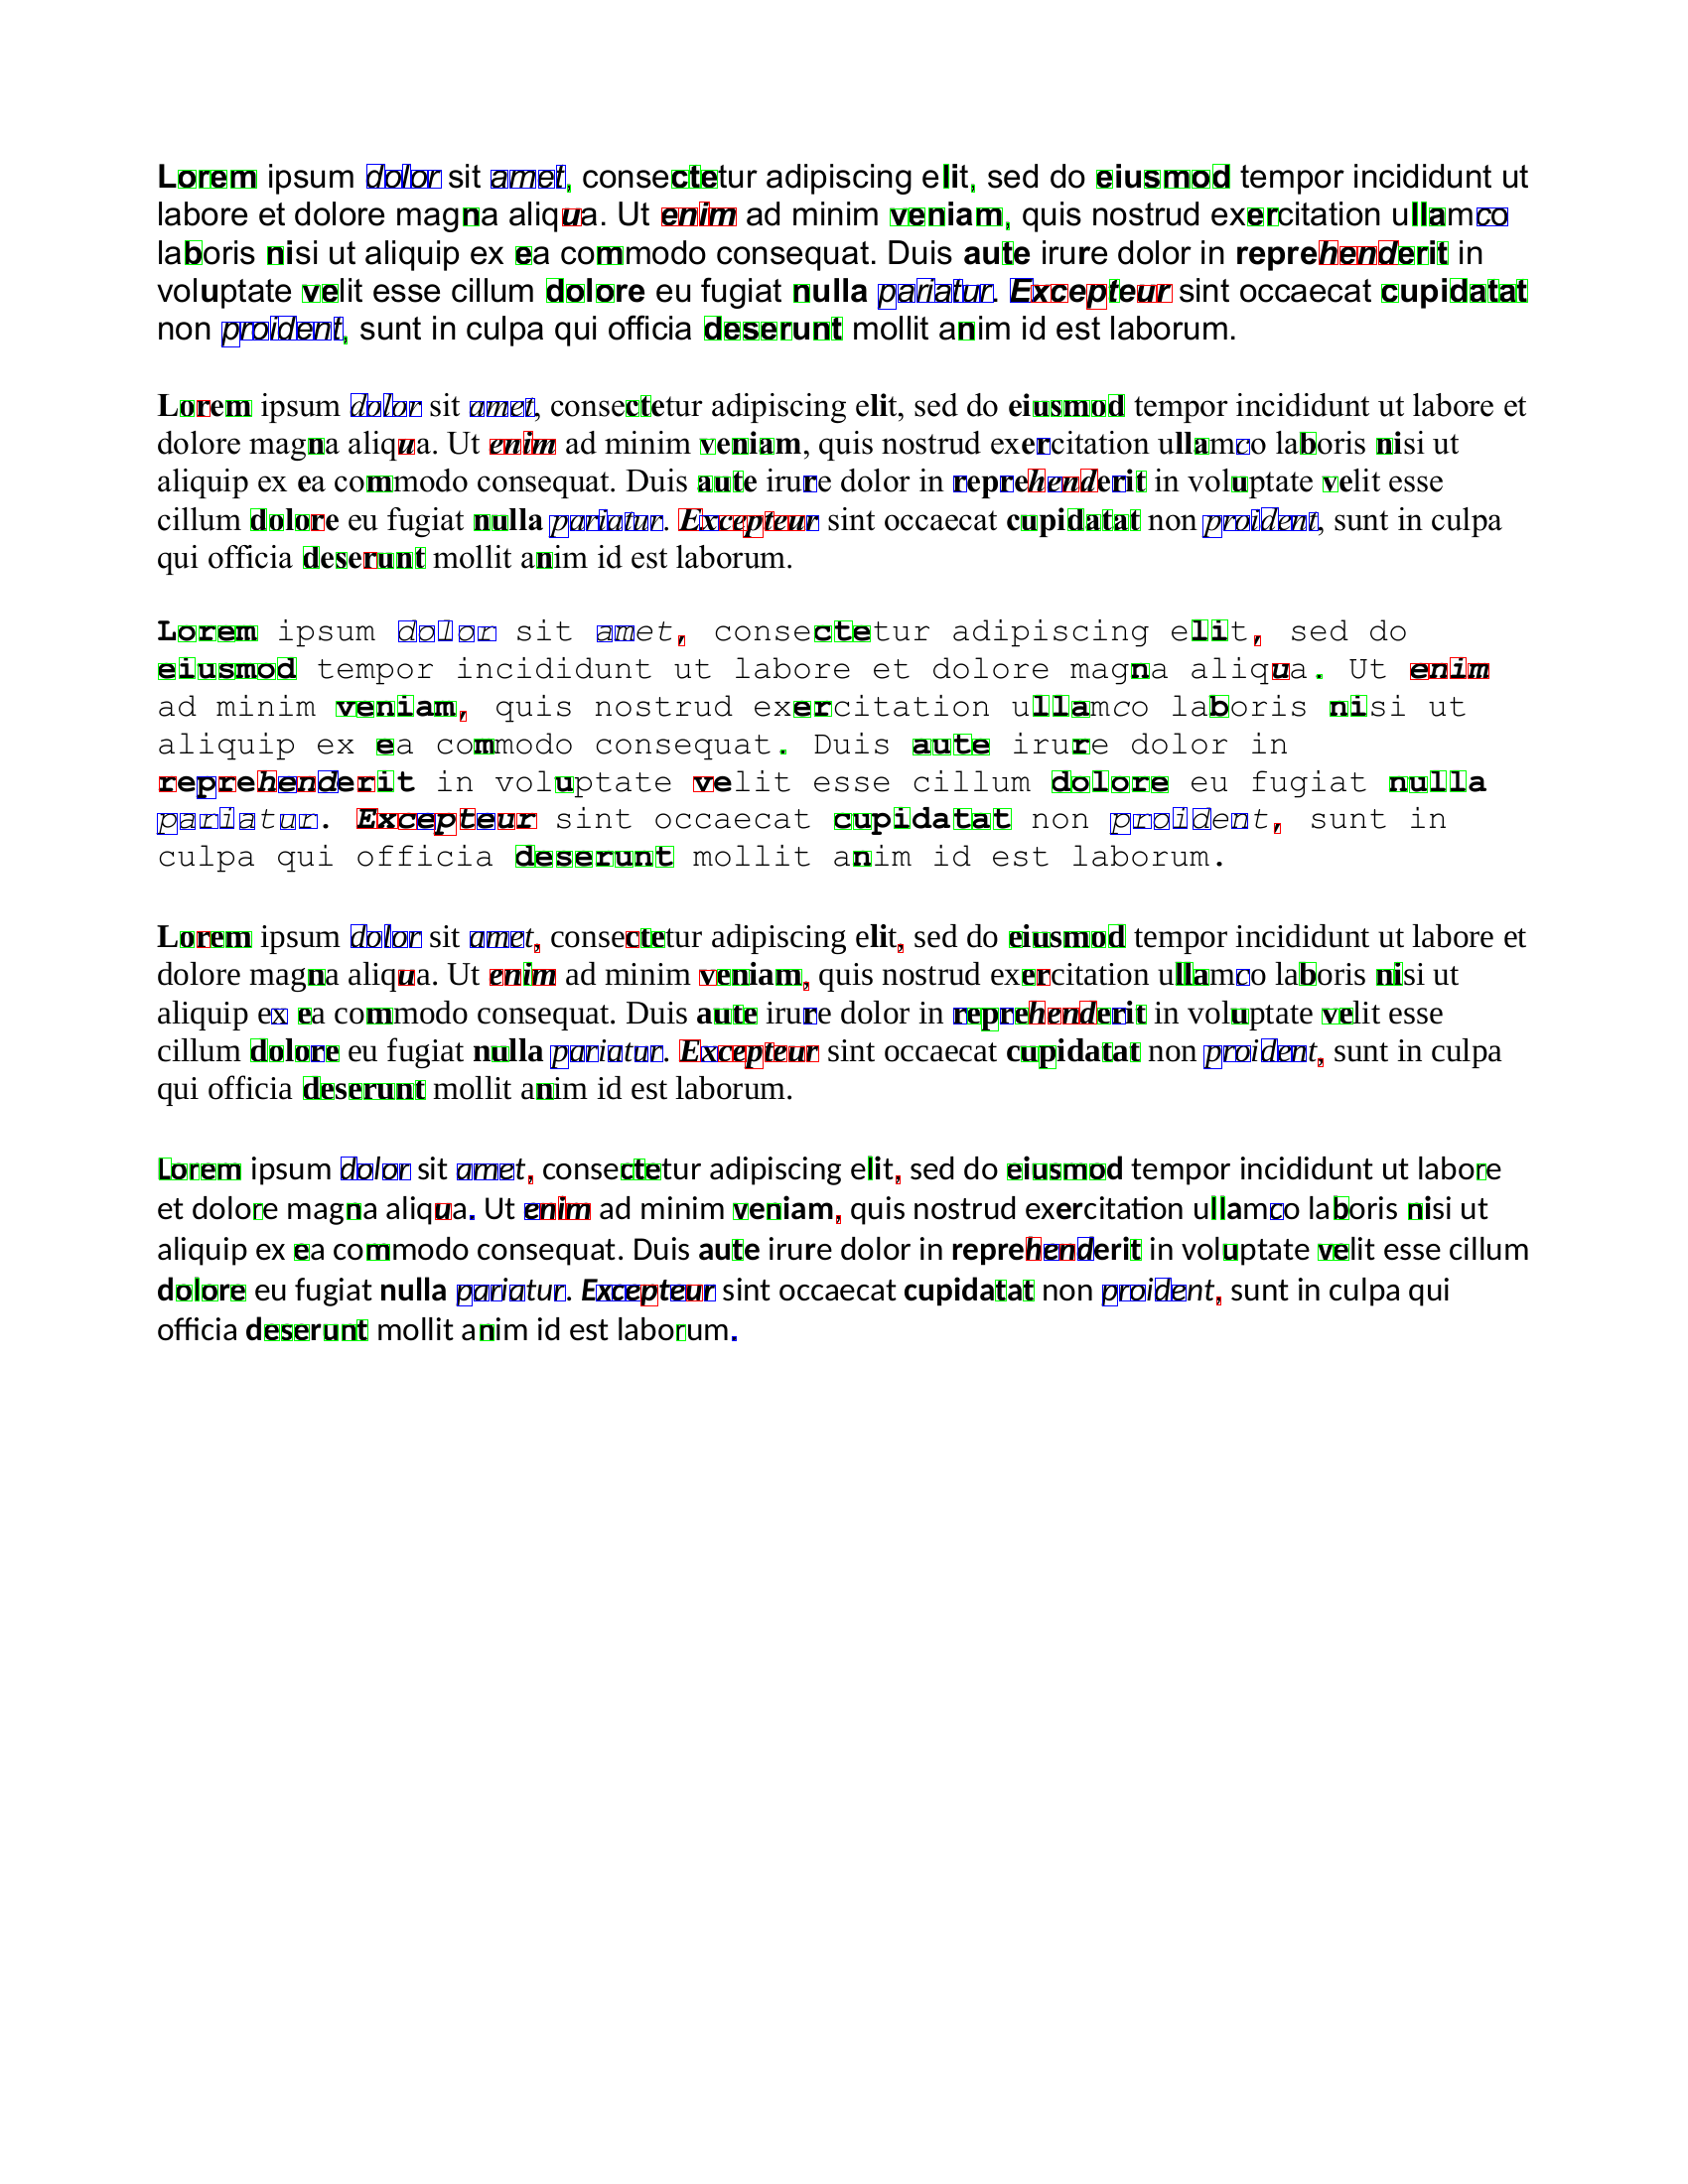

In [28]:
# Testing

# Convert pdf to images
os.makedirs("pdf_images", exist_ok=True)
paths = convert_from_path("sample.pdf", output_folder="pdf_images", output_file="pdf_page-", paths_only=True, use_pdftocairo=True)

for page_path in paths:
    # Get character bboxes from tesseract. Use legacy model since it has better character bboxes
    data = pytesseract.image_to_boxes(page_path, output_type="dict", config=r"--oem 0")

    image = Image.open(page_path)
    image.load()
    w, h = image.size
    draw = ImageDraw.Draw(image)

    # Crop characters
    char_crops = []
    for left, top, right, bottom in tqdm.tqdm(zip(data["left"], data["top"], data["right"], data["bottom"]), total=len(data["left"])):
        # draw.rectangle((left, h - top, right, h - bottom), outline=(255, 0, 0))
        char_crop = image.crop((left, h - top, right, h - bottom))
        img_size = 32
        # assert char_crop.width <= img_size and char_crop.height <= img_size
        # Letterbox image so that its size is img_size x img_size, same as during training
        char_img = CharacterDataset.letterbox_image(char_crop, img_size, 255)
        char_crops.append(CharacterDataset.pil_to_torch(char_img))

    data_loader = DataLoader(char_crops, batch_size=32, shuffle=False)

    # Add formatting info to tesseract data object
    data["bold"] = [False] * len(data["char"])
    data["italic"] = [False] * len(data["char"])

    i = 0
    for batch in data_loader:
        batch = batch.to(device)
        with torch.no_grad():
            logits = model(batch)
            predictions = logits >= 0
            bold, italic = predictions[:, 0], predictions[:, 1]

        # Draw predictions on document: bold+italic is red, bold is green, italic is blue
        for j in range(len(batch)):
            if bold[j] or italic[j]:
                bbox = data["left"][i+j], h - data["top"][i+j], data["right"][i+j], h - data["bottom"][i+j]
                if bold[j] and italic[j]:
                    color = (255, 0, 0)
                elif bold[j]:
                    color = (0, 255, 0)
                else:  # italic
                    color = (0, 0, 255)
                draw.rectangle(bbox, outline=color)
                data["bold"][i + j] = bool(bold[j])
                data["italic"][i + j] = bool(italic[j])
        i += len(batch)
    display(image)
    print()

    # `data` now has formatting information and could be used elsewhere